# Test for EEG masking

In [1]:
import mne
from mne.coreg import Coregistration
from mne.minimum_norm import make_inverse_operator, apply_inverse_epochs
import numpy as np
from pathlib import Path
import pandas as pd
import os
from pathlib import Path
import xarray as xr
import time
import gc
import dynsys_orig as dynsys
import matplotlib.pyplot as plt

In [2]:
def filter_labels_with_vertices(labels_parc, src):
    # Get the vertices from both hemispheres in the source space
    src_vertices = [src[0]['vertno'], src[1]['vertno']]
    
    # Initialize an empty list to hold valid labels
    valid_labels = []
    
    for label in labels_parc:
        # Determine the hemisphere index: 0 for 'lh' and 1 for 'rh'
        hemi_idx = 0 if label.hemi == 'lh' else 1
        
        # Check if any of the label's vertices are in the source space for that hemisphere
        if any(v in src_vertices[hemi_idx] for v in label.vertices):
            valid_labels.append(label)
        else:
            print(f'Label {label.name} was removed because it had no vertices in the source space')
            
    return valid_labels

In [4]:
#subjects = [subject for subject in os.listdir('/work/erikc/inspected') if subject.startswith('sub')]
#subjects_dir = "/work/erikc/inspected"
subject = 'sub-032304'
subjects_dir = '~/Code/functional connectivity/'
conditions = ['EC','EO']
eeg_dir = '~/Code/functional connectivity/eeg'
#eeg_dir = '/work/erikc/eeg'
src = mne.setup_source_space(subject, add_dist="patch", subjects_dir=subjects_dir)
raw = mne.io.read_raw_eeglab(f"{eeg_dir}/{subject}/{subject}_EC.set")

#Filter to alpha band
raw.load_data()
#raw.filter(8,12)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /Users/erikconnerty/Code/functional connectivity
Subject      = sub-032304
Surface      = white
Octahedron subdivision grade 6


KeyboardInterrupt: 

In [169]:
raw.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,64 points
Good channels,61 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


# Function to mask data based on percentage

In [170]:
def random_mask_eeg_data(raw, num_channels_to_mask,mask_percentage):

# Clone the raw data to avoid modifying the original object
    raw_masked = raw.copy()

    # Get all good channels
    good_channels = [ch for ch in raw.info['ch_names'] if ch not in raw.info['bads']]

    # Randomly select channels to mask
    selected_channels = np.random.choice(good_channels, num_channels_to_mask, replace=False)

    # Get the number of time points in the raw data
    n_times = raw.n_times

    # Calculate the number of points to mask in each channel
    n_points_to_mask = int(n_times * mask_percentage)

    for channel in selected_channels:
        print(f'Masking {n_points_to_mask} points in channel {channel}')
        # Get data for the channel
        channel_data, = raw_masked.get_data(picks=[channel])

        # Generate random indices to mask
        mask_indices = np.random.choice(n_times, n_points_to_mask, replace=False)

        # Mask the data
        channel_data[mask_indices] = 0.0
        # Update the data in the raw object
        raw_masked._data[raw_masked.ch_names.index(channel)] = channel_data

    return raw_masked

In [171]:
import numpy as np

def mask_continuous_chunks_eeg_data(raw, chunk_size, mask_percentage):
    """
    Masks specified percentage of data in the 'FC4' channel of a raw MNE EEG object 
    with zeros in continuous chunks.

    :param raw: MNE Raw object containing EEG data.
    :param chunk_size: Fixed size of each chunk to mask.
    :param mask_percentage: Percentage of data to mask in the 'FC4' channel.
    :return: Modified MNE Raw object with masked data.
    """
    # Clone the raw data to avoid modifying the original object
    raw_masked = raw.copy()

    # Channel to mask
    channel_to_mask = 'FC4'

    # Get the number of time points in the raw data
    n_times = raw.n_times

    # Calculate the total number of points to mask
    n_points_to_mask = int(n_times * mask_percentage)

    # Calculate the number of chunks needed
    num_chunks = int(np.ceil(n_points_to_mask / chunk_size))

    # Generate start indices for masking
    start_indices = np.random.choice(np.arange(n_times - chunk_size), 
                                     num_chunks, 
                                     replace=False)

    # Get data for the channel
    channel_data, = raw_masked.get_data(picks=[channel_to_mask])

    # Mask the data in chunks
    for start_idx in start_indices:
        end_idx = min(start_idx + chunk_size, n_times)
        channel_data[start_idx:end_idx] = 0.0

    # Update the data in the raw object
    raw_masked._data[raw_masked.ch_names.index(channel_to_mask)] = channel_data

    return raw_masked


In [172]:
masked_eeg = mask_continuous_chunks_eeg_data(raw, 1000, mask_percentage=0.2)

## Visualize data

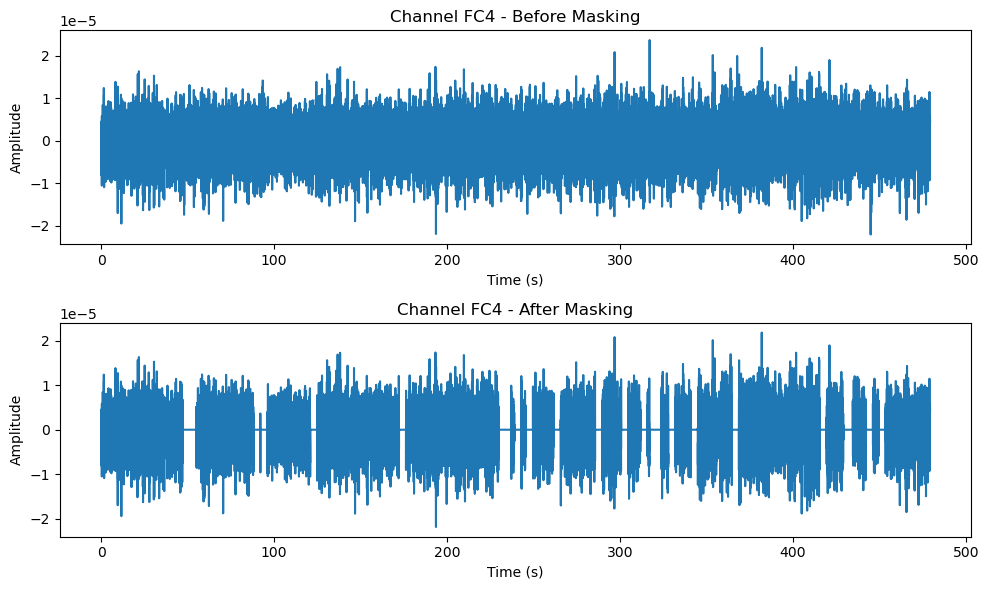

In [173]:
# Select the channel index
channel_idx = mne.pick_channels(raw.info['ch_names'], include=['FC5'])

# Extract data for the channel of interest before masking
data_before = raw.get_data(picks=channel_idx)

# Extract data for the channel of interest after masking
data_after = masked_eeg.get_data(picks=channel_idx)

# Get times
times = raw.times

# Plotting
plt.figure(figsize=(10, 6))

# Plot before masking
plt.subplot(2, 1, 1)
plt.plot(times, data_before.T)
plt.title(f"Channel FC4 - Before Masking")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Plot after masking
plt.subplot(2, 1, 2)
plt.plot(times, data_after.T)
plt.title(f"Channel FC4 - After Masking")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
#plt.show()

# Save the plot to a PDF
plt.savefig('masked_eeg.pdf')

# Compute forward solution

In [174]:
info = masked_eeg.info
fiducials = "estimated"
coreg = Coregistration(info, subject, subjects_dir, fiducials=fiducials)

conductivity = (0.3, 0.006, 0.3)
model = mne.make_bem_model(subject=subject, conductivity=conductivity, subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

epochs = mne.make_fixed_length_epochs(masked_eeg, duration=96.0, preload=False)
epochs.set_eeg_reference(projection=True)
epochs.apply_baseline((None,None))
fwd = mne.make_forward_solution(
    epochs.info, trans=coreg.trans, src=src, bem=bem, verbose=True
)

    Triangle neighbors and vertex normals...
Using low resolution head model in /Users/erikconnerty/Code/functional connectivity/sub-032304/bem/outer_skin.surf
    Triangle neighbors and vertex normals...
Estimating fiducials from fsaverage.
Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
outer skin  CM is   3.79 -19.06   6.52 mm
outer skull CM is   3.81 -18.92   6.09 mm
inner skull CM is   3.11 -21.04  14.32 mm
Checking that surface outer skull is inside surface outer skin  ...


KeyboardInterrupt: 

# Source reconstruction

In [ ]:
        
cov = mne.compute_covariance(epochs)

inv = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, cov, verbose=True)

method = "sLORETA"
snr = 3.0
lambda2 = 1.0 / snr**2
stc = apply_inverse_epochs(
    epochs,
    inv,
    lambda2,
    method=method,
    pick_ori=None,
    verbose=True,
    return_generator=False
)

labels_parc = mne.read_labels_from_annot(subject, parc='aparc', subjects_dir=subjects_dir)

filtered_labels = filter_labels_with_vertices(labels_parc, src)
label_ts = mne.extract_label_time_course(stc, filtered_labels, src, mode='auto', return_generator=False, allow_empty=False)

n=len(epochs)
region = [label.name for label in filtered_labels]

Using data from preloaded Raw for 4 events and 24000 original time points ...


0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 1.7e-10 (2.2e-16 eps * 61 dim * 1.3e+04  max singular value)
    Estimated rank (eeg): 60
    EEG: rank 60 computed from 61 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 61 -> 60
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 96000
[done]
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 61 channels.
    61 out of 61 channels remain after picking
Selected 61 channels
Creating the depth weighting matrix...
    61 EEG channels
    limit = 8197/8196 = 6.371300
    scale = 157912 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward soluti

# Compute dynsys

In [ ]:
mats=[]
for i in range(100):
    inds = np.random.choice(range(n),int(n/2),replace=False)
    epoch_data = np.array(label_ts)
    epoch_idx = np.arange(len(inds))
    dynsys_mat = dynsys.dynSys(epoch_data[inds], epoch_idx, region, sampling_time=0.0025)
    mats.append(dynsys_mat)

region = [label.name for label in filtered_labels]
bootstrap_samples = list(range(100))

xarray = xr.DataArray(np.array(mats), dims=["bootstrap_samples","region1","region2"],
coords={"bootstrap_samples":bootstrap_samples,"region1":region, "region2":region})
xarray.to_netcdf(f'./dynsys/{subject}_array_dynsys_EO_alpha.nc')

# Visualize result

In [ ]:
data_dir = './dynsys'

#Open dynsys nc array
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Open dynsys nc array
dynsys = nc.Dataset(data_dir+'/sub-032304_array_dynsys_EO_alpha.nc','r')

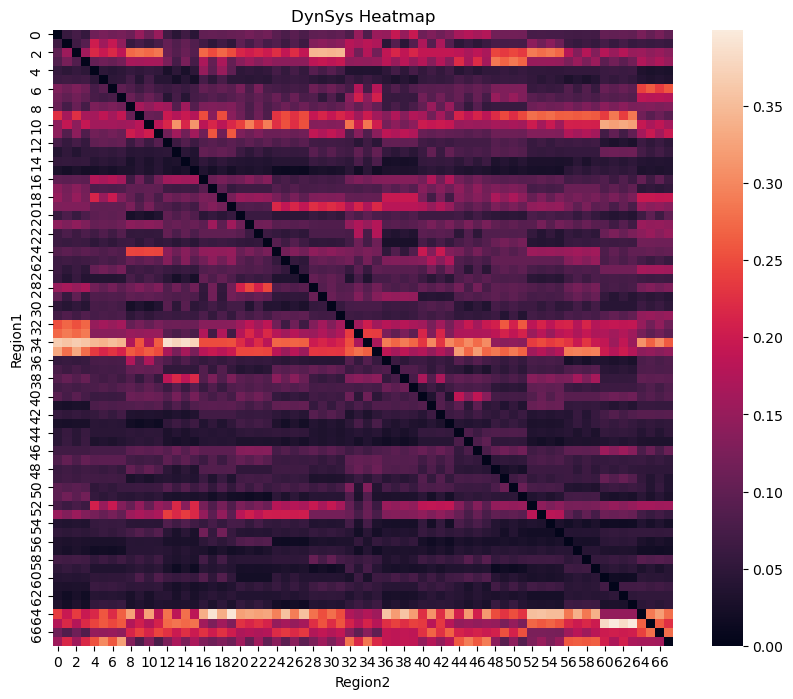

In [ ]:
# Extract the data from '__xarray_dataarray_variable__'
# Extract the data from '__xarray_dataarray_variable__'
data_variable = dynsys['__xarray_dataarray_variable__'][:]

# Compute the mean across the 'bootstrap_samples' dimension (which is axis=0)
mean_connectivity = np.mean(data_variable, axis=0)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(mean_connectivity, annot=False)
plt.title('DynSys Heatmap')
plt.xlabel('Region2')
plt.ylabel('Region1')
#plt.show()
plt.savefig('dynsys_heatmap_normal.pdf')

# Close the NetCDF file
dynsys.close()
